# Background

Model Predictive Control has been a long-standing subject of research and has found practical application across various domains. Nevertheless, a prevalent issue with these control strategies that rely on models is their significant reliance on accurately modeling dynamic systems, usually based on pre-established dynamics. The introduction of the SINDy algorithm in 2016<sup>[1]</sup> marked a significant shift. This algorithm enables the identification of profoundly nonlinear dynamics through the SINDy framework, eliminating the need for extensive datasets. This is particularly advantageous in real-life situations where low-data limit is prominent<sup>[2]</sup>, owing to the framework's strong generalisation capabilities<sup>[3]</sup> and low computational costs. The equation below shows the model learned with SINDy algorithm, consisting a model coefficient term and feature library term.

\begin{equation}
    \dot{X}=Θ(X)Ξ \label{eq:SINDy}
\end{equation}

Extensively developed in the 1980s, model predictive control employs online learning to forecast the subsequent N steps of states (referred to as the horizon) using $\dot{X}$. Within this horizon, a cost function is assigned. This function incorporates a weighted calculation of the disparity between the current state and the desired state (measured as ||current - target state||) along with the amount of control effort. By striking a balance between these factors, an optimal sequence of controls can be determined at each step. This approach has demonstrated remarkable efficacy, particularly when addressing constraints and obstacles within the optimisation problem. In this illustration, both the control and the prediction interval are aligned for simplicity, and a linear quadratic cost function is employed.
$$\begin{aligned} \min _{\hat{\mathbf{u}}\left(\cdot \mid \mathbf{x}_j\right)} J\left(\mathbf{x}_j\right)= & \min _{\hat{\mathbf{u}}\left(\cdot \mid \mathbf{x}_j\right)}\left[\sum_{k=0}^{N}\left\|\hat{\mathbf{x}}_{j+k}-\mathbf{x}_k^*\right\|_{\mathbf{Q}}^2\right.\left.+\sum_{k=0}^{N-1}\left(\left\|\hat{\mathbf{u}}_{j+k}\right\|_{\mathbf{R}}^2\right)\right]\end{aligned}$$

In this notebook, the CASADI python library, a symbolic framework for numerical optimisation is used due to its flexibility and customisation, active open-source community, and the popularity among academics.

<div style="border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #FFFFFF;">
  <h2 style="margin-bottom: 10px;">Table of Contents</h2>
  <ol style="list-style-type: decimal; padding-left: 20px;">
    <li><a href="#system-identification">System Identification</a></li>
    <li><a href="#mpc">Model Predictive Control</a></li>
    <li><a href="#results-and-visualisation">Results and Visualisation</a></li>
    <li><a href="#reference">Reference</a></li>
  </ol>
</div>

# Dependencies

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import casadi as ca
from itertools import combinations_with_replacement
from time import time

import pysindy as ps
from pysindy.utils import lorenz_control

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# plt.style.use("dark_background")

# System Identification <a id="system-identification"></a>

The choice of the chaotic Lorenz control system as our sample problem is deliberate for several reasons. This system serves as a benchmark for studying chaotic systems, offering a clear contrast to complex scenarios like the double-pendulum with intricate dynamics. Widely recognized and deeply understood, the Lorenz system represents a prominent instance of a nonlinear dynamic system showcasing chaotic traits. Despite its chaotic nature, these equations possess an analytical solution, facilitating a basis for accurate comparisons. The objective of this notebook is to achieve stabilisation of the state towards the two unstable equilibriums at coordinates (±√72,±√72,27).

\begin{aligned}
& \dot{x}=\sigma\left(y-x\right)+u \\
& \dot{y}=x\left(\rho-z\right)-y \\
& \dot{z}=xy-\beta z
\end{aligned}

To gather the data essential for system identification, we employ a Schroeder sweep to stimulate the system. The key strength of the Schroeder sweep lies in its capacity to span a wide array of frequencies in a relatively concise time span. When we implement the Schroeder sweep, we effectively provoke the system across a diverse range of frequencies simultaneously. This interplay between the sweep's dynamic frequency changes and the system's nonlinear characteristics unveils intricate behaviors that could remain concealed when employing basic sinusoidal inputs. In low data limit, the user can deploy an active learning strategy to further reduce the amount of data required.<sup>[2,4],</sup>

The subsequent steps in the SINDy learning process closely resemble those found in other instances within the PySindy repository, accessible at https://github.com/dynamicslab/pysindy/tree/master/examples. Readers are encouraged to explore these illustrative notebooks for additional insights and explanations.

Presented below is a class that consolidates all the steps involved in SINDy model learning, primarily for coding convenience.

In [2]:
class System:

    def __init__(self,sigma=10,beta=2.7,rho=28):
        # System parameters (Lorenz control)
        self.model_name = "Chaotic Lorenz System"
        self.sigma = sigma
        self.beta = beta
        self.rho = rho
        self.discrete = False

    def train_data(self):
        # Training timespan
        self.dt = 0.002
        self.t_end_train = 10
        self.t_end_test = 15
        self.t_train = np.arange(0,self.t_end_train,self.dt)
        self.x0_train = [-8,8,27]
        self.t_train_span = (self.t_train[0], self.t_train[-1])

        # Schroeder-phased harmonic sequence
        self.Pf = 8 # Fundamental period
        self.K = 16

    # Schroeder sweep
    def u_func(self,t):
        u = np.zeros_like(t)
        for i in range(1, self.K+1):
            theta = 2 * np.pi / self.K * np.sum(np.arange(1, i+1))
            u += np.sqrt(2/self.K) * np.cos(2 * np.pi * i * t / self.Pf + theta)

        if np.isscalar(t):
            return np.column_stack([u, 0]) # lorenz_control() in pysindy library has 2 inputs while we only have one 
        else:
            return u

    def model_fit(self):
        # Integrator keywords
        integrator_keywords = {}
        integrator_keywords["rtol"] = 1e-12
        integrator_keywords["method"] = "LSODA"
        integrator_keywords["atol"] = 1e-12

        self.u_train = self.u_func(self.t_train)
        self.x_train = solve_ivp(lorenz_control, self.t_train_span, self.x0_train, t_eval=self.t_train,
                                 **integrator_keywords,args=(self.u_func,self.sigma,self.beta,self.rho)).y.T
        feature_names = ["x","y","z","u"]

        ssr_optimizer = ps.SSR(alpha=0.05,criteria="model_residual",kappa=1e-1) # Optimiser SSR Greedy Optimiser
        self.library = ps.PolynomialLibrary(degree=2,include_bias=False).fit(self.x_train) # Feature Library
        self.model = ps.SINDy(optimizer=ssr_optimizer,feature_library=self.library,
                            feature_names=feature_names,discrete_time=self.discrete)
        self.model.fit(x=self.x_train,u=self.u_train,t=self.dt)
        self.feature_names = self.library.get_feature_names()
        print("All terms in the feature library")
        print(self.feature_names)
        print("Model Discovery (%s) :" % self.model_name)
        self.model.print()

# Model Predictive Control <a id="mpc"></a>

The MPC implementation section is inspired by Mohamed W. Mehrez's MPC tutorial which can be found here https://github.com/MMehrez/MPC-and-MHE-implementation-in-MATLAB-using-Casadi/tree/master/workshop_github/Python_Implementation.

<h2> Problem parameters </h2>

It's necessary to determine the level of significance we assign to the error in the states, which is denoted by the state penalty matrix Q. As the relative weighting of Q and R holds the actual significance, we manipulate the values of Q in this instance to illustrate this principle.  A higher coefficient represents to a greater emphasis on the corresponding state. In real life, this would have to be tuned based on the performance requirements and the constraints. In general, opting for a larger N tends to result in improved stability<sup>[5]</sup>, enhanced convergence, and reduced control effort. However, these advantages come at the expense of increased computational demands.

In [3]:
# Weight matrix penalty
Q_x, Q_y, Q_z = 3e3, 3e3, 3e3
R1 = 1
dt = 0.002
N = 10 # Horizon
sim_time = 4     # simulation time
vis_accel = 5 # Trajectory visualisation acceleration rate
states_target = ca.DM([np.sqrt(72),np.sqrt(72),27]) # Unstable equilibrium point

# System parameters
sigma = 10
beta = 8/3
rho = 28

<h2> System Variables </h2>

Subsequently, it's essential to define the state and control variables as [x, y, z] and [u], respectively. The uppercase letter X denotes the projected states across the prediction horizon, while uppercase letter U signifies the projected optimal sequence of controls at each time step. As highlighted earlier, Q and R stand as the weight factors in the cost function.

In [4]:
# state symbolic variables
x = ca.SX.sym('x')
y = ca.SX.sym('y')
z = ca.SX.sym('z')
states = ca.vertcat(x,y,z)
n_states = states.numel()

# control symbolic variables
u = ca.SX.sym('u')
controls = ca.vertcat(u)
n_controls = controls.numel()

# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)
U = ca.SX.sym('U', n_controls, N)

# coloumn vector for storing initial state and target state
P = ca.SX.sym('P', n_states + n_states)
# state weights matrix (Q_X, Q_Y, Q_z)
Q = ca.diagcat(Q_x, Q_y, Q_z)
# controls weights matrix
R = ca.diagcat(R1)

<h2> SINDy in Symbolic Form </h2

To solve the optimisation problem, the system dynamics which is the Chaotic Lorenz system would have to be represented symbolically. Traditionally, without using SINDy algorithm, the system can be represented easily with only 2-3 terms (in Lorenz) in each line of equation. However, when employing SINDy, the system takes on a different form where the model's coefficient matrix (notably sparse) is dot multiplied by the feature vector, encompassing all terms in the feature library.

The class provided below maps the concatenated symbolic states to a symbolic polynomial feature map. This process is similar to how ps.PolynomialLibrary() operates. For scenarios involving Fourier or custom libraries, the user would need to either create or hard-code a custom mapping function.

In [5]:
class SymbolicPolynomialLibrary:
    def __init__(self):
        pass

    def fit(self, variables, max_degree, include_bias=True):
        self.variables = variables
        self.max_degree = max_degree
        self.include_bias = include_bias
        self.feature_expressions = []

        if self.include_bias:
            self.feature_expressions.append(1)  # Include a bias term (constant)

        for deg in range(1, self.max_degree + 1):
            for combo in combinations_with_replacement(self.variables, deg):
                feature_expression = 1
                for var in combo:
                    feature_expression *= var
                self.feature_expressions.append(feature_expression)

        return self.feature_expressions
    
    def get_feature_map(self):
        return self.feature_expressions
    
    def print_feature_names(self):
        print("Symbolic terms of the feature library (degree %d)" % self.max_degree)
        for feature in self.feature_expressions:
            print(feature, end=",")
        print()

In [6]:
degree = 2
include_bias = False

states_concat = [x,y,z,u]   
library = SymbolicPolynomialLibrary()
library.fit(variables=states_concat,max_degree=degree,include_bias=include_bias)
states_mapped = library.get_feature_map()
library.print_feature_names()

Symbolic terms of the feature library (degree 2)
x,y,z,u,sq(x),(x*y),(x*z),(x*u),sq(y),(y*z),(y*u),sq(z),(z*u),sq(u),


As shown below, SINDy is a powerful algorithm capable of identifying all the terms in the Chaotic Lorenz sytem.

In [7]:
system = System(sigma=sigma,beta=beta,rho=rho)
system.train_data()
system.model_fit()
print("\nFull model coefficients")
np.set_printoptions(threshold=np.inf, linewidth=300)
print(system.model.coefficients())

RHS = system.model.coefficients() @ states_mapped
# Chaotic Lorenz system mapping from [x,y,z,u].T to [x,y,z]_dot.T
f = ca.Function('f', [states, controls], [RHS])

All terms in the feature library
['x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2']
Model Discovery (Chaotic Lorenz System) :
(x)' = -9.999 x + 10.000 y + 1.000 u
(y)' = 27.989 x + -0.996 y + -1.000 x z
(z)' = -2.667 z + 0.999 x y

Full model coefficients
[[-9.99904144e+00  9.99954635e+00  0.00000000e+00  9.99631458e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.93887617e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.79890896e+01 -9.96372560e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.99689509e-01  0.00000000e+00  0.00000000e+00 -6.85780967e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.66669084e+00  0.00000000e+00  2.91330909e-04  9.99441649e-01  0.00000000e+00  0.00000000e+00  1.91946533e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [8]:
# Set the initial state of the refrence tracking phase to the end of the training phase
states_init = ca.DM(system.x_train[-1,:])

<h2> Cost function </h2>

The Runge-Kutta scheme is employed to forecast forthcoming states, which along with the control inputs will be symbolically stored in the cost function. The variable "g" represents the equality constraint vector in the context of multishooting (both X and U are optimised instead of U). This approach ensures that the predicted state aligns with the actual state in the subsequent time step. The multishooting strategy compared to singleshooting enhances computational efficiency and leads to improved constraint handling.

In [9]:
cost_fn = 0  # cost function
g = X[:, 0] - P[:n_states]  # constraints in the equation

# Runge Kutta 4 numerical scheme
for k in range(N):
    st = X[:, k]
    con = U[:, k]
    
    # Cost function
    cost_fn = cost_fn \
        + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    
    # Predict next state
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + dt/2*k1, con)
    k3 = f(st + dt/2*k2, con)
    k4 = f(st + dt * k3, con)
    st_next_RK4 = st + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    
    g = ca.vertcat(g, st_next - st_next_RK4) # equality constraints

<h2> Solver settings </h2>

Combining all the previously mentioned configurations to create a non-linear solver.

In [10]:
OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': cost_fn,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': int(sim_time/dt),
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

<h2> Solver constraints </h2>

The constraints introduced in this notebook are arbitrarily chosen. Nevertheless, in real-world scenarios, the constraints imposed are contingent upon design specifications and the specific context of the problem.

In [11]:
lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -400     # X lower bound
lbx[1: n_states*(N+1): n_states] = -400     # Y lower bound
lbx[2: n_states*(N+1): n_states] = -300     # z lower bound


ubx[0: n_states*(N+1): n_states] = 400      # X upper bound
ubx[1: n_states*(N+1): n_states] = 400      # Y upper bound
ubx[2: n_states*(N+1): n_states] = 500      # z upper bound

lbx[n_states*(N+1):] = -200              # u lower bound for all u
ubx[n_states*(N+1):] = 200                # u upper bound for all u

args = {
    'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # equality constraints lower bound (= 0)
    'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # equality constraints upper bound (= 0)
    'lbx': lbx,
    'ubx': ubx
}

In [12]:
t0 = 0
t_hist = ca.DM(t0)
cost_hist = []

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(states_init, 1, N+1) # initial state full

mpc_iter = 0
states_hist = np.array(X0.full())
controls_hist = np.array(u0[:, 0].full())
times = np.array([[0]]) # Successive computational time

<h2> Core of MPC </h2>

The "next_timestep" function produces the time, predicted state, and the subsequent control input for the next time step. Meanwhile, the "solver_arguments" function updates the parameter "p" (particularly the current initial state) and adjusts the optimisation variables within the cost function. This adjustment is necessary as the previous values for the initial state and control are discarded.

In [13]:
######################### MPC Hidden Code #########################
def next_timestep(dt, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (dt * f_value))

    t0 = t0 + dt
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )
    return t0, next_state, u0

def solver_arguments(states_init,states_target,X0,u0):
    args_p = ca.vertcat(
        states_init,    # current state
        states_target   # target state
    )
    # optimisation variable current state
    args_x0 = ca.vertcat(
        ca.reshape(X0, n_states*(N+1), 1),
        ca.reshape(u0, n_controls*N, 1)
    )
    return args_p, args_x0

def store_history(states_hist,controls_hist,cost,X0,u,t_hist,t0):
    states_hist = np.dstack((states_hist,np.array(X0.full())))
    controls_hist = np.vstack((controls_hist,np.array(u[:, 0].full())))
    t_hist = np.vstack((t_hist,t0))
    cost_hist.append(cost)
    return states_hist, controls_hist, t_hist

The MPC process unfolds in the subsequent manner: initially, acquire the optimal sequence of forecasted states and control inputs from the solver based on the cost function. Subsequently, eliminate the initial state and controls by shifting all values from the second to the last column forward by one position. Lastly, store the history of states and controls and increment mpc_iter by one. This iterative loop continues until convergence is achieved or the time limit is surpassed.

In [14]:
if __name__ == '__main__':
    main_loop = time()  # return time in sec
    tolerance = 1e-1
    # while (ca.norm_2(states_init - states_target) > tolerance) and (mpc_iter * dt < sim_time):
    while (mpc_iter * dt < sim_time): # Check if stabilises
        t1 = time()

        # MPC Core
        args['p'], args['x0'] = solver_arguments(states_init,states_target,X0,u0)
        sol = solver(x0=args['x0'],lbx=args['lbx'],ubx=args['ubx'],
                     lbg=args['lbg'],ubg=args['ubg'],p=args['p']) # RK4 Simulation and Optimisation
        
        u_cat = ca.reshape(sol['x'][n_states * (N + 1):], n_controls, N)
        X0 = ca.reshape(sol['x'][: n_states * (N+1)], n_states, N+1)
        cost = sol["f"]
        
        states_hist, controls_hist, t_hist = store_history(states_hist,controls_hist,cost,X0,u_cat,t_hist,t0)
        X0 = ca.horzcat(X0[:, 1:],ca.reshape(X0[:, -1], -1, 1))
        t0, states_init, u0 = next_timestep(dt, t0, states_init, u_cat, f)

        
        t2 = time()
        times = np.vstack((times,t2-t1))
        mpc_iter = mpc_iter + 1

    main_loop_time = time()
    ss_error = ca.norm_2(states_init - states_target)

    print('Total CPU time: %f (s)' % (main_loop_time - main_loop))
    print('Average CPU iteration time: %f (ms)' % (np.array(times).mean() * 1000))
    # print("Simulation time required for convergence: %f (s)" % t_hist[-1,0])
    print("Iteration (%d)" % mpc_iter)
    print("final state discrepancy : %f " % ss_error)
    print("Final State :",np.array(states_init).flatten())


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total CPU time: 10.130046 (s)
Average CPU iteration time: 5.049930 (ms)
Iteration (2000)
final state discrepancy : 0.009310 
Final State : [ 8.48429666  8.48050879 27.00793258]


# Results and Visualisation <a id="results-and-visualisation"></a>

In [15]:
def data_states_retrieve(states_hist):
    data = np.zeros((states_hist.shape[0],states_hist.shape[2]))
    for i in range(states_hist.shape[2]):
        data[0,i] = states_hist[0, 0, i]
        data[1,i] = states_hist[1, 0, i]
        data[2,i] = states_hist[2, 0, i]

    return data

def data_controls_retrieve(controls_hist):
    data = np.zeros((controls_hist.shape[0],controls_hist.shape[1]))
    for i in range(controls_hist.shape[0]):
        data[i] = controls_hist[i, 0]

    return data

data_states = data_states_retrieve(states_hist)
data_controls = data_controls_retrieve(controls_hist)

As shown from the system dynamics, the control input u can only directly affect x but not y and z. Thus, it is relatively more difficult to converge for y and z state, leading to more overshooting and longer settling time.

In [16]:
# Check if the 'ffmpeg' movie writer is available
def check_ffmpeg_writer_available():
    return any(writer == 'ffmpeg' for writer in animation.writers.list())

if check_ffmpeg_writer_available():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Animation function
    def animate(i):
        # ax.clear()
        ax.plot(data_states[0,:vis_accel*i], data_states[1,:vis_accel*i], data_states[2,:vis_accel*i],"black")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Trajectory Animation')

    dpi = 150
    ani = FuncAnimation(fig, animate, frames=int(len(t_hist)/vis_accel), interval=50)
    video = ani.to_html5_video()
    html = HTML(video)
    display(html)
    plt.close()
else:
    print("FFmpeg is not installed or not available.")

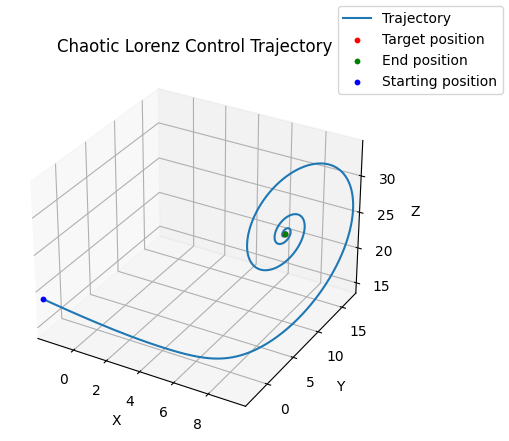

In [17]:
# Final results
fig = plt.figure(2)
ax = fig.add_subplot(projection='3d')
# Setting the axes properties
ax.set_xlim3d([np.min(data_states[0,:]), np.max(data_states[0,:])])
ax.set_xlabel('X')
ax.set_ylim3d([np.min(data_states[1,:]), np.max(data_states[1,:])])
ax.set_ylabel('Y')
ax.set_zlim3d([np.min(data_states[2,:]), np.max(data_states[2,:])])
ax.set_zlabel('Z')
ax.set_title("Chaotic Lorenz Control Trajectory")
ax.plot(data_states[0,:], data_states[1,:], data_states[2,:])
ax.scatter(states_target[0], states_target[1], states_target[2], color='red', s=10)
ax.scatter(data_states[0,-1], data_states[1,-1], data_states[2,-1], color='green', s=10)
ax.scatter(data_states[0,0], data_states[1,0], data_states[2,0], color='blue', s=10)
fig.legend(["Trajectory","Target position","End position","Starting position"])
plt.show()

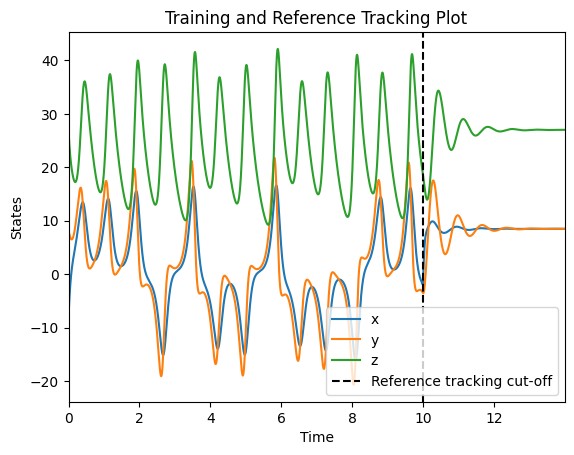

In [18]:
def states_plot(t_train,x_train,t_hist,data):
    t_control = np.array(t_hist).flatten()+t_train[-1]
    all_data = np.vstack((x_train,data_states.T))
    all_time = np.hstack((t_train,t_control))
    plt.plot(all_time,all_data[:,0])
    plt.plot(all_time,all_data[:,1])
    plt.plot(all_time,all_data[:,2])
    # Training and trajectory tracking cut-off
    plt.axvline(x=t_train[-1], color='black', linestyle='--', label='Vertical Line')

    plt.title("Training and Reference Tracking Plot")
    plt.xlabel("Time")
    plt.ylabel("States")
    plt.legend(["x","y","z","Reference tracking cut-off"])
    plt.xlim([all_time[0],all_time[-1]])

# Plots the variation of states with time
states_plot(system.t_train,system.x_train,t_hist,data_states)

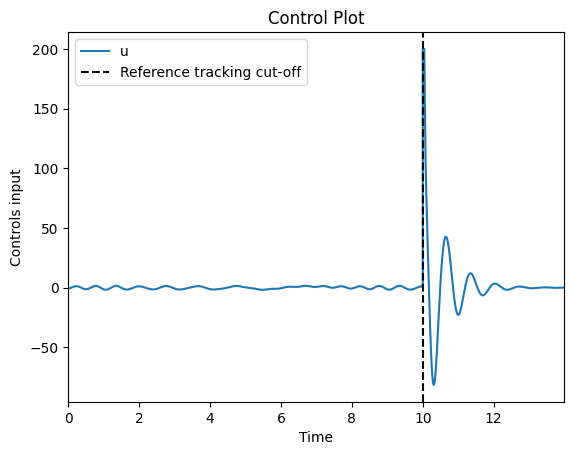

In [19]:
def controls_plot(t_train,u_train,t_hist,data):
    t_control = np.array(t_hist).flatten()+t_train[-1]
    all_data = np.hstack((u_train,data.flatten()))
    all_time = np.hstack((t_train,t_control))

    plt.plot(all_time,all_data)
    # Training and trajectory tracking cut-off
    plt.axvline(x=t_train[-1], color='black', linestyle='--', label='Vertical Line')

    plt.title("Control Plot")
    plt.xlabel("Time")
    plt.ylabel("Controls input")
    plt.xlim([all_time[0],all_time[-1]])
    plt.legend(["u","Reference tracking cut-off"])
    
controls_plot(system.t_train,system.u_train,t_hist,data_controls)

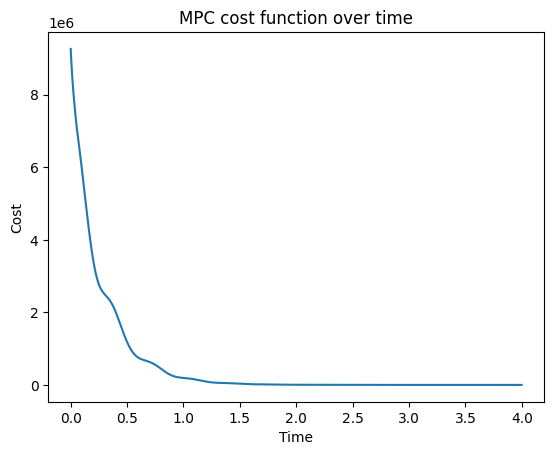

In [20]:
def cost_plot(t_hist,cost_hist):
    plt.plot(t_hist[1:],np.array(cost_hist).flatten())
    plt.title("MPC cost function over time")
    plt.xlabel("Time")
    plt.ylabel("Cost")
    plt.show()
    
cost_plot(t_hist,cost_hist)

# Reference <a id="reference"></a>

[1] Brunton SL, Proctor JL, Kutz JN. Discovering governing equations from data by sparse identification of nonlinear dynamical systems. Proceedings of the National Academy of Sciences. 2016 Mar 28;113(15):3932–7.
‌<br>
‌<br>
[2] Kaiser E, Kutz JN, Brunton SL. Sparse identification of nonlinear dynamics for model predictive control in the low-data limit. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences. 2018 Nov;474(2219):20180335.
‌‌<br>
‌<br>
[3] Fasel U, J. Nathan Kutz, Brunton BW, Brunton SL. Ensemble-SINDy: Robust sparse model discovery in the low-data, high-noise limit, with active learning and control. Proceedings of The Royal Society A: Mathematical, Physical and Engineering Sciences. 2022 Apr 1;478(2260).
‌‌<br>
‌<br>
[4] Mania H, Jordan MI, Recht B. Active Learning for Nonlinear System Identification with Guarantees. arXiv (Cornell University). 2020 Jun 18.
‌<br>
‌<br>
[5] Dimitri Bertsekas. A Course in Reinforcement Learning. Athena Scientific; 2023
‌